In [49]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [50]:
df = pd.read_csv("augmented_dataset.csv")

# df = df.drop(columns=['BMI', 'BSA', 'IMT MAX', 'LVMi', 'EF', 'Record'])

# df['Gender'] = df['Gender'].str.upper().map({'M': 0, 'F': 1})
# df['Smoker'] = df['Smoker'].str.upper().map({'NO': 0, 'YES': 1})
df.head()

,Age,Weight,Height,SBP,DBP,Smoker,Gender,Vascular event
0,56,104.963004,177.892854,139.417249,85.303739,1,0,none
1,80,79.218044,164.826315,175.238742,73.442780,0,1,none
2,77,89.155377,178.397928,138.890499,89.451412,0,0,none
3,66,80.156848,172.108310,102.858142,62.881078,0,1,none
4,84,72.357701,167.408929,124.863981,68.530730,0,0,none


In [51]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [52]:
model = CTGANSynthesizer(metadata=metadata, epochs=500)

/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/home/elukbog/.local/lib/python3.10/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [53]:
model.fit(df)

# Generate synthetic data
synthetic_crfs = model.sample(1000)
synthetic_crfs.to_csv("synthetic_crfs.csv", index=False)

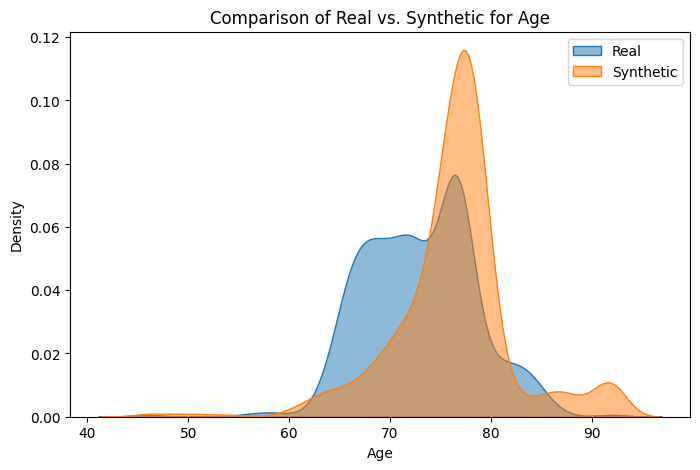

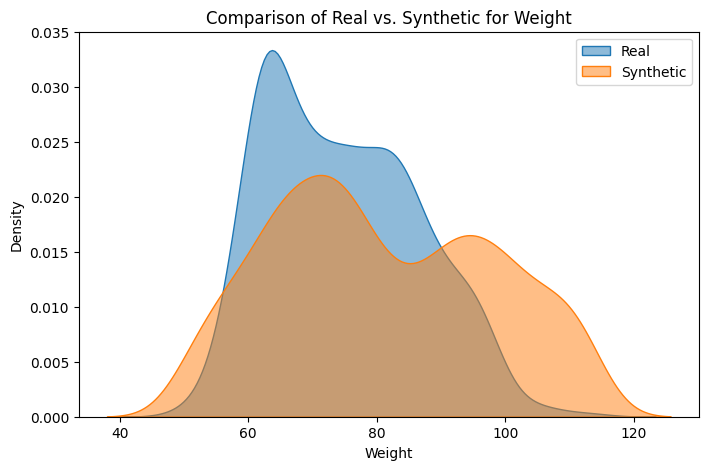

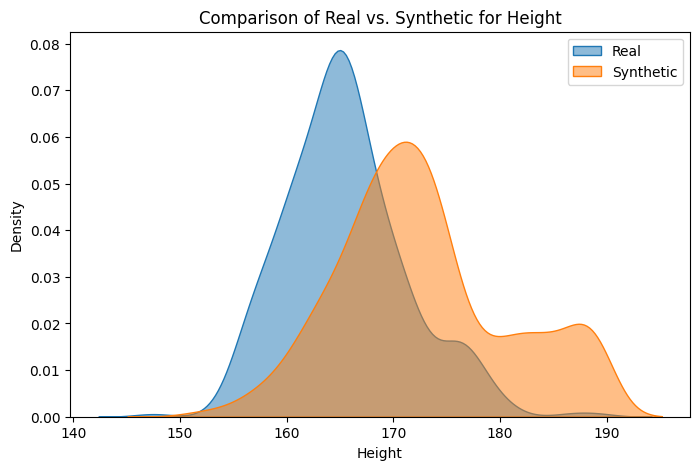

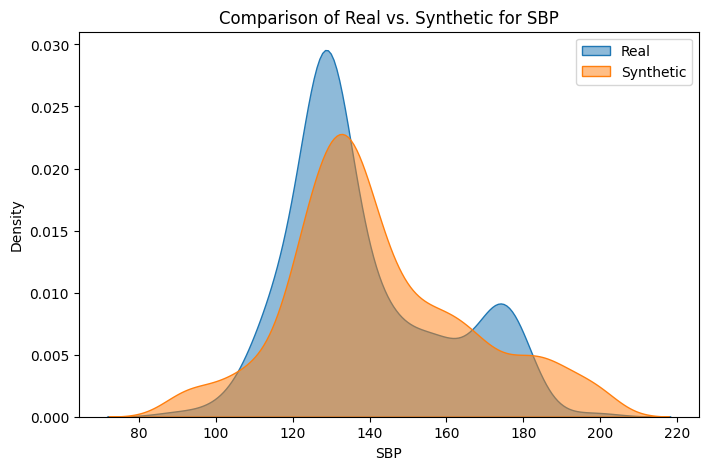

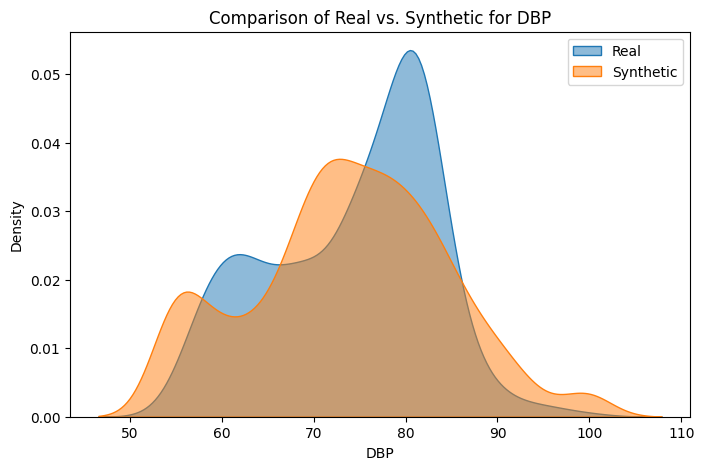

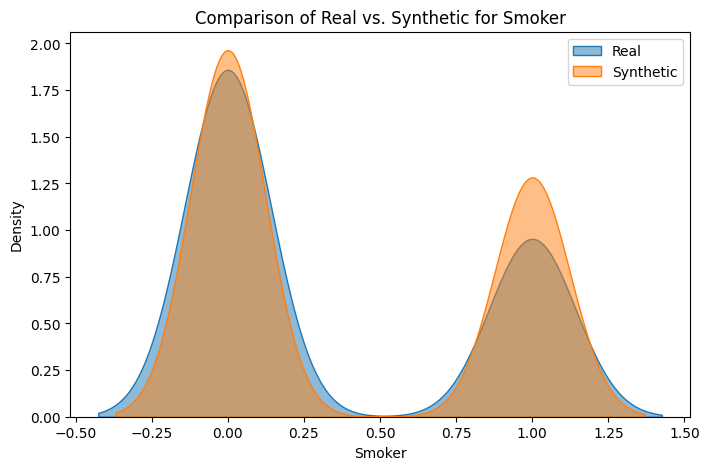

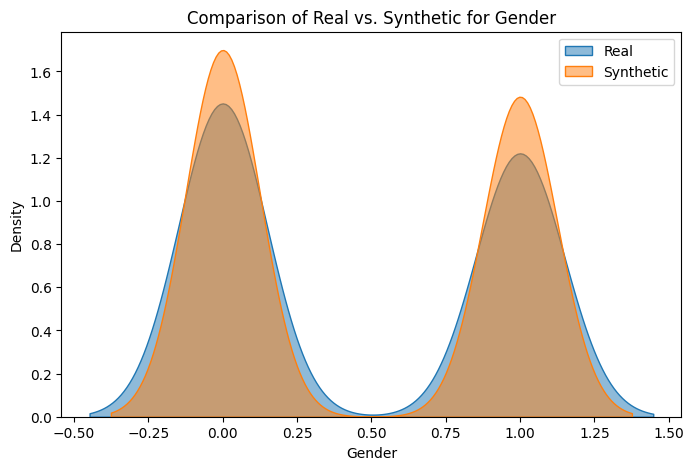

In [54]:
def distrib_comp():
    for column in df.columns:
        if column != "Vascular event":
            plt.figure(figsize=(8, 5))
            sns.kdeplot(df[column], label="Real", fill=True, alpha=0.5)
            sns.kdeplot(synthetic_crfs[column],
                        label="Synthetic", fill=True, alpha=0.5)
            plt.title(f"Comparison of Real vs. Synthetic for {column}")
            plt.legend()
            plt.show()

distrib_comp()

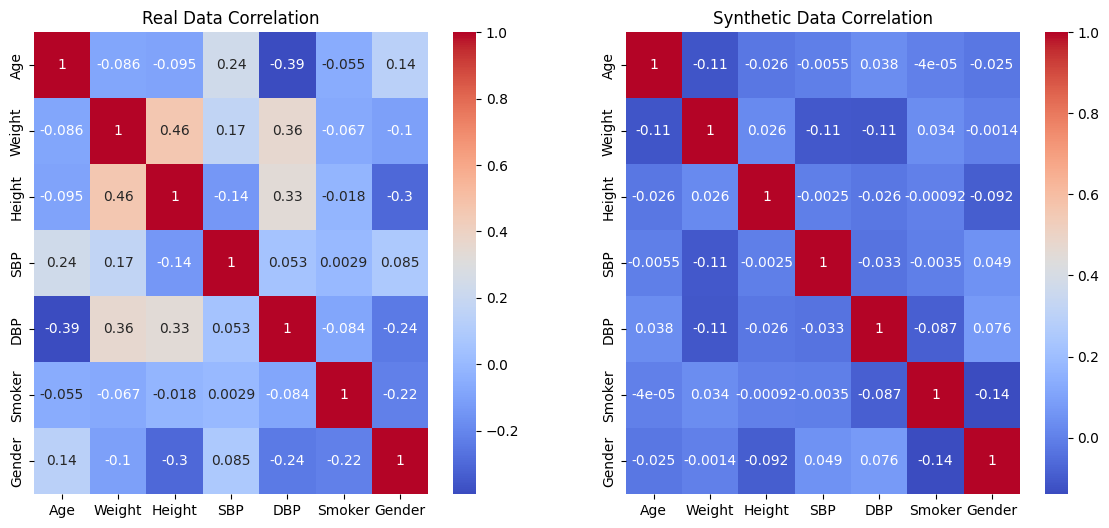

In [55]:
def correlation_heatmap():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(df.drop(columns=["Vascular event"]).corr(), ax=axes[0], cmap="coolwarm", annot=True)
    axes[0].set_title("Real Data Correlation")
    sns.heatmap(synthetic_crfs.drop(columns=["Vascular event"]).corr(), ax=axes[1], cmap="coolwarm", annot=True)
    axes[1].set_title("Synthetic Data Correlation")
    plt.show()

correlation_heatmap()

In [56]:
def stat_distance_metric():
    for column in df.columns:
        if column != 'Vascular event':
            wd = wasserstein_distance(df[column], synthetic_crfs[column])
            ks_stat, ks_p = ks_2samp(df[column], synthetic_crfs[column])
            print(f"Feature: {column}")
            print(f"  Wasserstein Distance: {wd:.4f}")
            print(f"  KS Test p-value: {ks_p:.4f}")
            print("-" * 30)

stat_distance_metric()

Feature: Age
  Wasserstein Distance: 3.5065
  KS Test p-value: 0.0000
------------------------------
Feature: Weight
  Wasserstein Distance: 7.2348
  KS Test p-value: 0.0000
------------------------------
Feature: Height
  Wasserstein Distance: 7.2722
  KS Test p-value: 0.0000
------------------------------
Feature: SBP
  Wasserstein Distance: 4.7861
  KS Test p-value: 0.0000
------------------------------
Feature: DBP
  Wasserstein Distance: 1.9806
  KS Test p-value: 0.0070
------------------------------
Feature: Smoker
  Wasserstein Distance: 0.0561
  KS Test p-value: 0.3006
------------------------------
Feature: Gender
  Wasserstein Distance: 0.0093
  KS Test p-value: 1.0000
------------------------------


In [57]:
target_column = "Vascular event"
X_real = df.drop(columns=[target_column])
X_real = X_real.fillna(X_real.mean())
y_real = df[target_column]
X_syn = synthetic_crfs.drop(columns=[target_column])
X_syn = X_syn.fillna(X_syn.mean())
y_syn = synthetic_crfs[target_column]

In [58]:
# Train on real, test on synthetic
X_train, X_test, y_train, y_test = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_syn = clf.predict(X_syn)
real_to_syn_acc = accuracy_score(y_syn, pred_syn)

In [59]:
# Train on synthetic, test on real
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, random_state=42)
clf_syn = RandomForestClassifier()
clf_syn.fit(X_train_syn, y_train_syn)
pred_real = clf_syn.predict(X_real)
syn_to_real_acc = accuracy_score(y_real, pred_real)

print(f"Train on Real → Test on Synthetic Accuracy: {real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.2290
Train on Synthetic → Test on Real Accuracy: 0.3774


In [60]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.25      0.22      0.23       222
                 none       0.22      0.78      0.34       208
               stroke       0.22      0.01      0.01       267
              syncope       0.31      0.05      0.09       303

             accuracy                           0.23      1000
            macro avg       0.25      0.27      0.17      1000
         weighted avg       0.26      0.23      0.15      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.32      0.21      0.25       104
                 none       0.49      0.27      0.35       104
               stroke       0.34      0.49      0.40       104
              syncope       0.40      0.54      0.46       104

             accuracy                           0.38       416

In [61]:
svm_real = SVC()
svm_real.fit(X_train, y_train)
svm_real_pred = svm_real.predict(X_syn)
svm_real_to_syn_acc = accuracy_score(y_syn, svm_real_pred)
svm_syn = SVC()
svm_syn.fit(X_train_syn, y_train_syn)
svm_syn_pred = svm_syn.predict(X_real)
svm_syn_to_real_acc = accuracy_score(y_real, svm_syn_pred)

print(f"Train on Real → Test on Synthetic Accuracy: {svm_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real Accuracy: {svm_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic Accuracy: 0.2580
Train on Synthetic → Test on Real Accuracy: 0.2500


In [62]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.25      0.22      0.23       222
                 none       0.22      0.78      0.34       208
               stroke       0.22      0.01      0.01       267
              syncope       0.31      0.05      0.09       303

             accuracy                           0.23      1000
            macro avg       0.25      0.27      0.17      1000
         weighted avg       0.26      0.23      0.15      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.32      0.21      0.25       104
                 none       0.49      0.27      0.35       104
               stroke       0.34      0.49      0.40       104
              syncope       0.40      0.54      0.46       104

             accuracy                           0.38       416

In [63]:
knn_real = KNeighborsClassifier()
knn_real.fit(X_train, y_train)
knn_real_pred = knn_real.predict(X_syn)
knn_real_to_syn_acc = accuracy_score(y_syn, knn_real_pred)

knn_syn = KNeighborsClassifier()
knn_syn.fit(X_train_syn, y_train_syn)
knn_syn_pred = knn_syn.predict(X_real)
knn_syn_to_real_acc = accuracy_score(y_real, knn_syn_pred)

print(f"Train on Real → Test on Synthetic (KNN) Accuracy: {knn_real_to_syn_acc:.4f}")
print(f"Train on Synthetic → Test on Real (KNN) Accuracy: {knn_syn_to_real_acc:.4f}")

Train on Real → Test on Synthetic (KNN) Accuracy: 0.2320
Train on Synthetic → Test on Real (KNN) Accuracy: 0.2548


In [64]:
print(f"Train on Real → Test on Synthetic Classification Report:\n{classification_report(y_syn, pred_syn)}")
print(f"Train on Synthetic → Test on Real Classification Report:\n{classification_report(y_real, pred_real)}")

Train on Real → Test on Synthetic Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.25      0.22      0.23       222
                 none       0.22      0.78      0.34       208
               stroke       0.22      0.01      0.01       267
              syncope       0.31      0.05      0.09       303

             accuracy                           0.23      1000
            macro avg       0.25      0.27      0.17      1000
         weighted avg       0.26      0.23      0.15      1000

Train on Synthetic → Test on Real Classification Report:
                       precision    recall  f1-score   support

myocardial infarction       0.32      0.21      0.25       104
                 none       0.49      0.27      0.35       104
               stroke       0.34      0.49      0.40       104
              syncope       0.40      0.54      0.46       104

             accuracy                           0.38       416

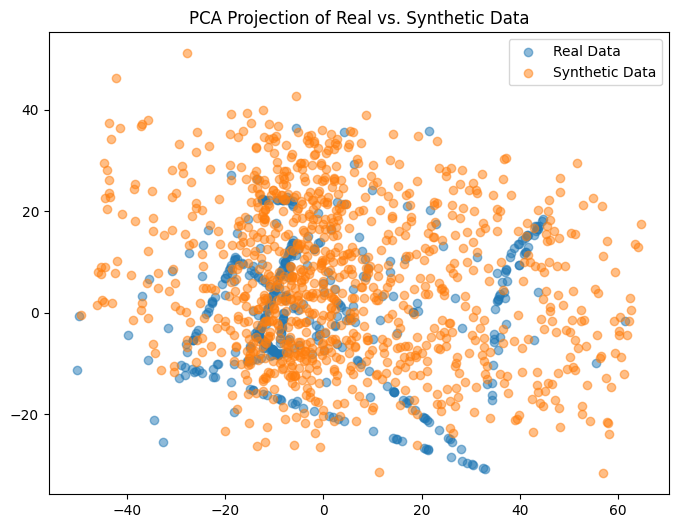

In [65]:
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X_real)
synthetic_pca = pca.transform(X_syn)
plt.figure(figsize=(8, 6))
plt.scatter(real_pca[:, 0], real_pca[:, 1], label="Real Data", alpha=0.5)
plt.scatter(synthetic_pca[:, 0], synthetic_pca[:, 1],
            label="Synthetic Data", alpha=0.5)
plt.legend()
plt.title("PCA Projection of Real vs. Synthetic Data")
plt.show()

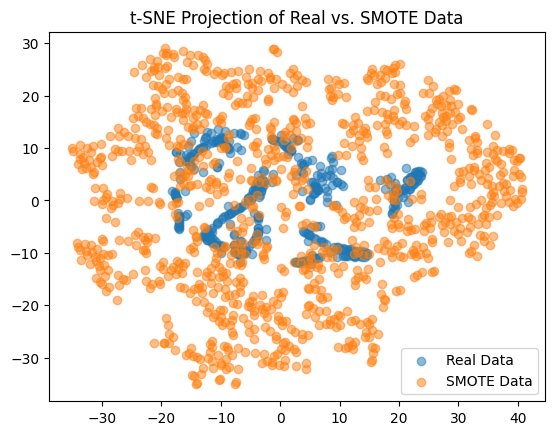

In [66]:
# t-SNE for deeper structure validation
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_real_tsne = tsne.fit_transform(X_real)
X_smote_tsne = tsne.fit_transform(X_syn)

plt.scatter(X_real_tsne[:,0], X_real_tsne[:,1], label="Real Data", alpha=0.5)
plt.scatter(X_smote_tsne[:,0], X_smote_tsne[:,1], label="SMOTE Data", alpha=0.5)
plt.legend()
plt.title("t-SNE Projection of Real vs. SMOTE Data")
plt.show()